In [28]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys, os

import re

In [7]:
type(float)

type

In [8]:
np.typeDict['float']

numpy.float64

In [9]:
from Sis2 import readsis as readsis

In [10]:
MAG = 2**16/10

def make_fake_sis(im):
    fake_sis0 = im.copy()
    fake_sis0 = fake_sis0*MAG
    fake_sis0[fake_sis0<0] = 0
    fake_sis0 = fake_sis0.astype(np.uint16) # questo dovrebbe simulare il salvataggio come .sis

    fake_sis = fake_sis0/MAG  # e questo è quello che faccio quando la riapro
    return fake_sis

In [26]:
def read_pgm(filename, byteorder='>', full_output=False):
    """
    Return image data from a raw PGM file as numpy array.
    Format specification: http://netpbm.sourceforge.net/doc/pgm.html
    """
    with open(filename, 'rb') as f:
        buffer = f.read()
    try:
        header, width, height, maxval = re.search(
            b"(^P5\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    except AttributeError:
        raise ValueError("Not a raw PGM file: '%s'" % filename)
    image = np.frombuffer(buffer,
                            dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                            count=int(width)*int(height),
                            offset=len(header)
                            ).reshape((int(height), int(width)))
    if full_output:
        return header, image
    else:
        return image
    

# Note importanti

1) **Abbiamo un `nan` dove:**

* probe = 0 --> nan per log(0): questo dove non arriva il probe (non dovrebbe esserci)
* atoms = 0 --> nan per 1/0: questo dove non arriva il probe **oppure** dove ho saturazione

2) ** Quando salvo come .sis, ovvero converto in `uint16`** 

    tutti i nan diventano 0
    
cazzo

3) Se uso il background calcolo

    OD = log((probe-bg)/(atoms-bg))
    
e mi becco un sacco di nan dove ho saturazione, perché dopo la sottrazione ho il rumore attorno a 0

# use_background = `True`

You are opening the SisV2 file: mypicture.sis
It says: '00000...
...and was created on '2017-02-14 17:54:10'
The commit of the program is: prova000'


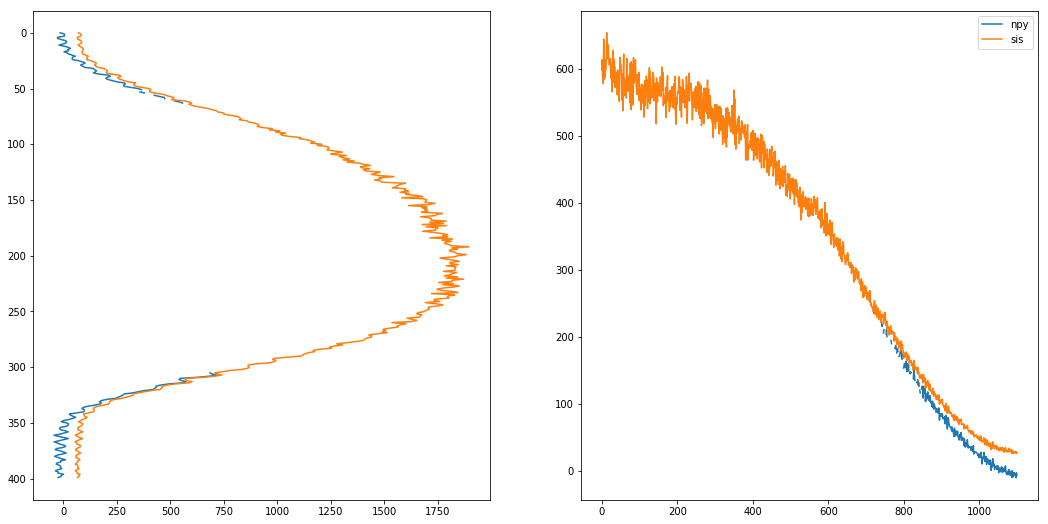

In [20]:
im_npy = np.load('mypicture.npy')
im_sis = readsis('mypicture.sis', verbose=True)[0]/(2**16/10)

area = (slice(600, 1000), slice(None, 1100))

fig, (axv, ax) = plt.subplots(1,2, figsize=(18,9))
axv.invert_yaxis()

h, w = im_npy[area].shape
x = np.arange(w)
y = np.arange(h)

ax.plot(im_npy[area].sum(0), label='npy')
ax.plot(im_sis[area].sum(0), label='sis')

axv.plot(im_npy[area].sum(1), y, label='npy')
axv.plot(im_sis[area].sum(1), y, label='sis')

ax.legend(loc=0)

# use_background = `False`

You are opening the SisV2 file: mypicture_nobg.sis
It says: '00000...
...and was created on '2017-02-14 01:16:11'
The commit of the program is: prova000'


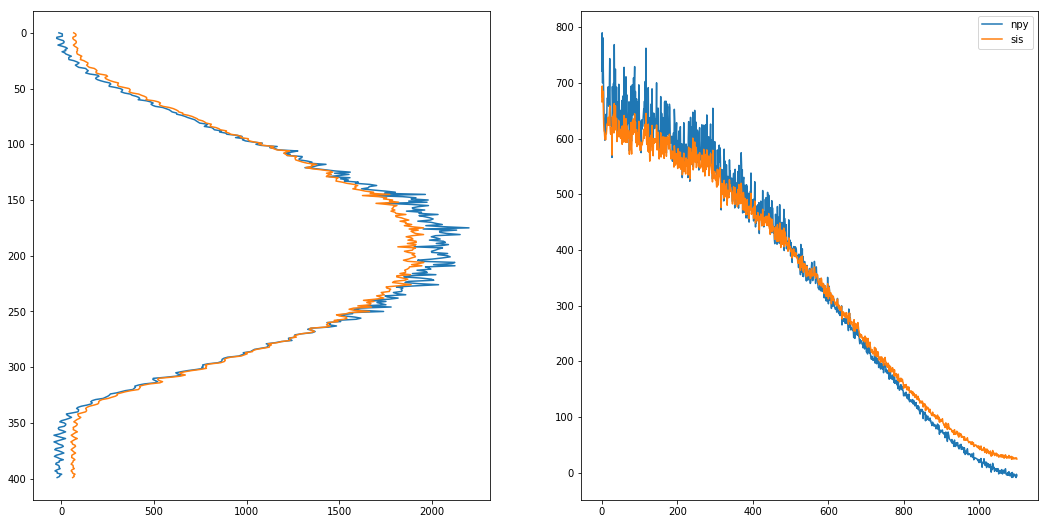

In [12]:
im_nobg_npy = np.load('mypicture_nobg.npy')
im_nobg_sis = readsis('mypicture_nobg.sis', verbose=True)[0]/(2**16/10)

area = (slice(600, 1000), slice(None, 1100))

fig, (axv, ax) = plt.subplots(1,2, figsize=(18,9))
axv.invert_yaxis()

h, w = im_nobg_npy[area].shape
x = np.arange(w)
y = np.arange(h)

ax.plot(im_nobg_npy[area].sum(0), label='npy')
ax.plot(im_nobg_sis[area].sum(0), label='sis')

axv.plot(im_nobg_npy[area].sum(1), y, label='npy')
axv.plot(im_nobg_sis[area].sum(1), y, label='sis')

ax.legend(loc=0)

# cfr

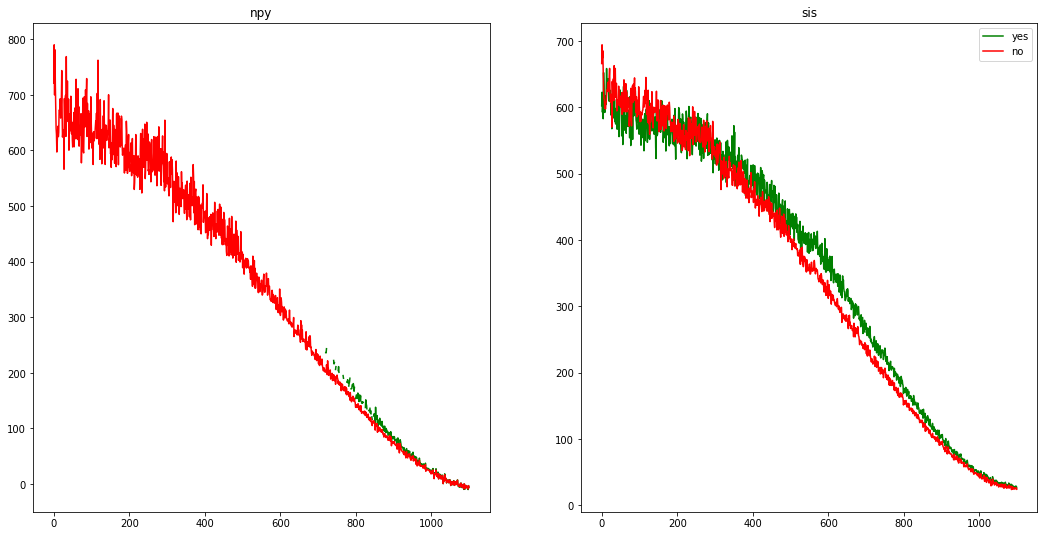

In [13]:
fig, (axnp, axsis) = plt.subplots(1,2, figsize=(18,9))

axnp.set_title('npy')
axnp.plot(im_npy[area].sum(0), 'g', label='yes')
axnp.plot(im_nobg_npy[area].sum(0), 'r', label='no')

axsis.set_title('sis')
axsis.plot(im_sis[area].sum(0), 'g', label='yes')
axsis.plot(im_nobg_sis[area].sum(0), 'r', label='no')

axsis.legend(loc=0)

In [14]:
fake = make_fake_sis(im_npy)

/usr/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in less


In [15]:
np.all(fake == im_sis)

True

In [16]:
np.any(np.isnan(im_npy))

True

In [17]:
wh_nan = np.where(np.isnan(im_npy))

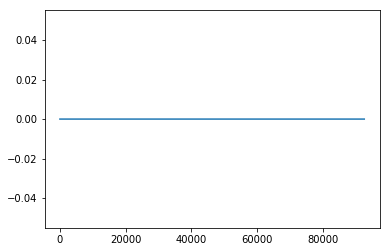

In [18]:
plt.plot(fake[wh_nan])

In [19]:
im_npy.dtype

dtype('float64')

In [21]:
BG = np.load('mypicture_bg.npy')

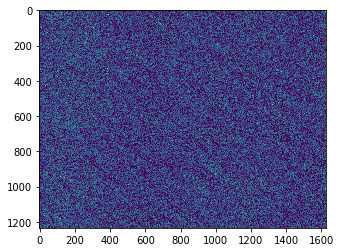

In [22]:
plt.imshow(BG)

(array([  6.20026000e+05,   4.66616000e+05,   4.31246000e+05,
          2.85579000e+05,   1.36176000e+05,   4.90160000e+04,
          1.22660000e+04,   2.68100000e+03,   3.78000000e+02,
          3.20000000e+01]),
 array([   0. ,   43.6,   87.2,  130.8,  174.4,  218. ,  261.6,  305.2,
         348.8,  392.4,  436. ]),
 <a list of 10 Patch objects>)

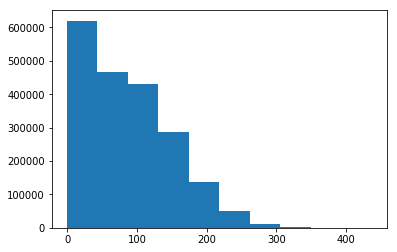

In [23]:
plt.hist(BG.ravel())

In [33]:
BG.mean()

84.316999465074133

In [25]:
BG.min()

0.0

In [35]:
BG.std()

65.396309113348678

In [36]:
ATOMS = read_pgm('picture_NaK/tof-0000000000.ppm')
PROBE = read_pgm('picture_NaK/tof-0000000001.ppm')

In [31]:
BG_pgm = read_pgm('tof-0000000003.ppm')

(array([  6.62212000e+05,   5.10576000e+05,   4.06969000e+05,
          2.69375000e+05,   1.08800000e+05,   3.66670000e+04,
          7.93500000e+03,   1.28800000e+03,   1.77000000e+02,
          1.70000000e+01]),
 array([   0. ,   46.4,   92.8,  139.2,  185.6,  232. ,  278.4,  324.8,
         371.2,  417.6,  464. ]),
 <a list of 10 Patch objects>)

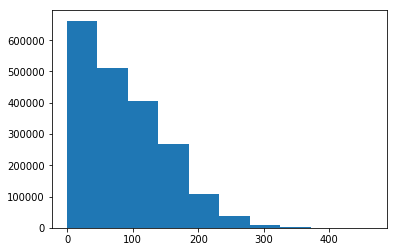

In [32]:
plt.hist(BG_pgm.ravel())

(0, 64967.0)

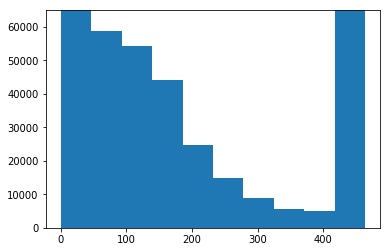

In [41]:
u = PROBE.copy()
np.clip(u, 0, 464, u)
fig, ax = plt.subplots()
ax.hist(u.ravel())
ax.set_ylim(0, 64967.)

(array([  2.75256000e+05,   3.79590000e+04,   1.91426000e+05,
          5.31688000e+05,   5.82075000e+05,   3.00116000e+05,
          7.51180000e+04,   9.58800000e+03,   7.53000000e+02,
          3.70000000e+01]),
 array([    0. ,   357.2,   714.4,  1071.6,  1428.8,  1786. ,  2143.2,
         2500.4,  2857.6,  3214.8,  3572. ]),
 <a list of 10 Patch objects>)

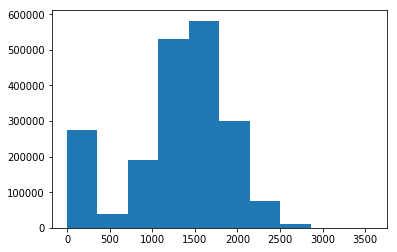

In [43]:
plt.hist(PROBE.ravel())

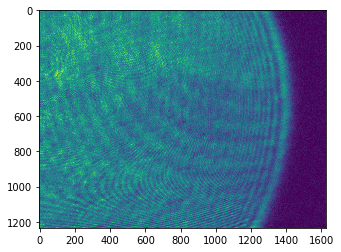

In [42]:
plt.imshow(PROBE)